In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.constants as const

class PoissonSolver2D:
    def __init__(self, grid_shape, epsilon, doping_profile, bias_boundaries, tolerance=1e-3, max_iterations=1000):
        self.grid_shape = grid_shape
        self.epsilon = epsilon
        self.doping_profile = doping_profile
        self.bias_boundaries = bias_boundaries  # Add bias boundaries
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.phi = np.zeros(grid_shape)
        self.rho = np.zeros(grid_shape)

    def solve(self, electron_density):
        """Solve the Poisson equation using Gauss-Seidel iteration."""
        iteration = 0
        error = np.inf
        
        while iteration < self.max_iterations and error > self.tolerance:
            phi_prime = self.phi.copy()

            # Update rho (charge density) based on the electron density
            # self.rho = self.update_rho(electron_density)

            # Iterate over the internal grid points
            for i in range(1, self.grid_shape[0] - 1):
                for j in range(1, self.grid_shape[1] - 1):

                    if self.boundary_source(i, j):
                        phi_prime[i,j] = self.bias_boundaries[0]
                    elif self.boundary_drain(i, j):
                        phi_prime[i,j] = self.bias_boundaries[1]
                    elif self.boundary_gate(i, j):
                        phi_prime[i,j] = self.bias_boundaries[2]
                    elif self.boundary_top(i, j):
                        phi_prime[i,j] = self.bias_boundaries[3]
                    else: 
                        phi_prime[i, j] = 0.25 * (self.phi[i + 1, j] + self.phi[i - 1, j] + self.phi[i, j + 1] + self.phi[i, j - 1] - self.rho[i, j])

            # Compute the error
            error = np.max(np.abs(phi_prime - self.phi))
            self.phi = phi_prime
            iteration += 1

            if iteration % 100 == 0:
                print(f"Iteration {iteration}, Error: {error:.6f}")

        if error <= self.tolerance:
            print(f"Solution converged in {iteration} iterations.")
        else:
            print(f"No Convergence; Iteration: {self.max_iterations}, Error: {error:.6f}")

        return self.phi

    def boundary_gate(self, x, y):
        if (int(self.grid_shape[0] / 3.0) < x < int(2 * self.grid_shape[0] / 3.0)) and (y == 0):
            return self.bias_boundaries[0]
        else:
            return 0
    
    def boundary_source(self, x, y):
        if (x < int(self.grid_shape[0] / 3.0)) and (y == int(self.grid_shape[1] - 1)):
            return self.bias_boundaries[1]
        else:
            return 0
        
    def boundary_drain(self, x, y):
        if (x > int(2 * self.grid_shape[0] / 3.0)) and (y == int(self.grid_shape[1] - 1)):
            return self.bias_boundaries[2]
        else:
            return 0
    
    def boundary_top(self, x, y):
        if (int(self.grid_shape[0] / 3.0) < x < int(2 * self.grid_shape[0] / 3.0)) and (y == int(self.grid_shape[1] - 1)):
            return self.bias_boundaries[3]
        else:
            return 0
    
    def apply_boundary_conditions(self):
        """Apply boundary conditions to the grid."""
        X, Y = self.grid_shape
    
        # Assuming to not overlap
        for i in range(X):
            self.phi[0, i] = self.boundary_gate(i, 0)
            self.phi[Y-1, i] = self.boundary_top(i, Y-1) + self.boundary_source(i, Y-1) + self.boundary_drain(i, Y-1)  # Bottom

            self.rho[0, i] = self.boundary_gate(i, 0)
            self.rho[Y-1, i] = self.boundary_top(i, Y-1) + self.boundary_source(i, Y-1) + self.boundary_drain(i, Y-1)  # Bottom

    # def update_rho(self, electron_density):
    #     if electron_density is None:
    #         raise ValueError("Electron density is None. Make sure it's computed before solving Poisson.")
            
    #     """Update the charge density (rho) based on electron density."""
    #     return const.e * (5e18 - electron_density) / self.epsilon


class ElectronDensity2D:
    """Computes 2D electron density using Fermi-Dirac distribution and DOS"""
    def __init__(self, temperature, fermi_level, dos_function=None):
        self.temperature = temperature
        self.fermi_level = fermi_level
        self.dos_function = dos_function  # Function to compute DOS at a given energy
    
    def compute(self, eigenvalues, wavefunctions):

        if self.dos_function is not None:
            """Compute new electron density with DOS included"""
            # Compute the Fermi-Dirac distribution for each eigenvalue
            fermi_dist = 1 / (np.exp((eigenvalues - self.fermi_level) / (const.k * self.temperature)) + 1)
            
            # Calculate the density by summing up the wavefunctions, weighting by the DOS and Fermi-Dirac distribution
            density = np.zeros_like(wavefunctions[:, :, 0])  # Initialize an empty density grid
            for i in range(wavefunctions.shape[2]):
                energy = eigenvalues[i]
    
    
                # Apply the DOS function to the energy level
                dos = self.dos_function(energy)
                
                # The electron density at each point is weighted by the DOS and the Fermi-Dirac distribution
                density = (np.abs(wavefunctions[:, :, i])**2 * dos * fermi_dist[i])
                
        else:
                fermi_dist = 1 / (np.exp((eigenvalues - self.fermi_level) / (const.k * self.temperature)) + 1)
                density = np.sum(np.abs(wavefunctions) ** 2 * fermi_dist[np.newaxis, np.newaxis, :], axis=2) 

        return density
        



class SchrodingerSolver2D:
    def __init__(self, grid_shape, effective_mass):
        self.grid_shape = grid_shape
        self.effective_mass = effective_mass

    def solve(self, potential):
        """Solves the 2D Schrödinger equation"""
        Nx, Ny = self.grid_shape
        dx = dy = 1e-9
        N = Nx * Ny

        H = sp.lil_matrix((N, N))

        for i in range(N):
            H[i, i] = 4 / dx ** 2 + potential.flatten()[i]
            if i % Nx != 0:
                H[i, i - 1] = -1 / dx ** 2
            if (i + 1) % Nx != 0:
                H[i, i + 1] = -1 / dx ** 2
            if i >= Nx:
                H[i, i - Nx] = -1 / dx ** 2
            if i < N - Nx:
                H[i, i + Nx] = -1 / dx ** 2

        H *= -const.hbar ** 2 / (2 * self.effective_mass * const.m_e)
        H = sp.csr_matrix(H)

        eigenvalues, eigenvectors = spla.eigsh(H, k=10, which='SM')
        wavefunctions = eigenvectors.reshape((Nx, Ny, -1))

        return eigenvalues, wavefunctions


class SchrodingerPoissonSolver2D:
    """Self-consistent 2D Schrödinger-Poisson solver"""
    def __init__(self, grid_shape, epsilon, effective_mass, doping_profile, temperature, fermi_level, bias_boundaries, dos_function=None, tol=1e-7, max_iter=10000):
        self.grid_shape = grid_shape
        self.poisson = PoissonSolver2D(grid_shape, epsilon, doping_profile, bias_boundaries)
        self.schrodinger = SchrodingerSolver2D(grid_shape, effective_mass)
        self.electron_density_solver = ElectronDensity2D(temperature, fermi_level, dos_function)
        self.tol = tol
        self.max_iter = max_iter

    def solve(self):
        """Solves the coupled Schrödinger-Poisson system iteratively"""
        Nx, Ny = self.grid_shape
        n_old = None # Must assume None otherwise assumes entire grid is all biased to 0 and will converge in 1-shot

        # Initialize grid with boundary conditions from the Poisson solver
        self.poisson.apply_boundary_conditions()

        n_old = self.poisson.solve(n_old)
        
        for iteration in range(self.max_iter):
            phi = self.poisson.solve(n_old)
            energy_levels, wavefunctions = self.schrodinger.solve(phi)
            n_new = self.electron_density_solver.compute(energy_levels, wavefunctions)
            
            # print(n_old)

            error = np.linalg.norm(n_new - n_old)
            print(f"Iteration {iteration + 1}: Error = {error}")

            if error < self.tol:
                print("Converged!")
                break

            n_old = n_new

        return phi, energy_levels, wavefunctions, n_new


Iteration 100, Error: 0.003859
Iteration 200, Error: 0.001958
Iteration 300, Error: 0.001112
Solution converged in 319 iterations.
Solution converged in 1 iterations.
Iteration 1: Error = 27.0149523006848
Solution converged in 1 iterations.
Iteration 2: Error = 6.577389141520019e-09
Converged!


<bound method Axes.legend of <Axes: title={'center': 'Quantum Energy Levels'}, xlabel='Index', ylabel='Energy (eV)'>>

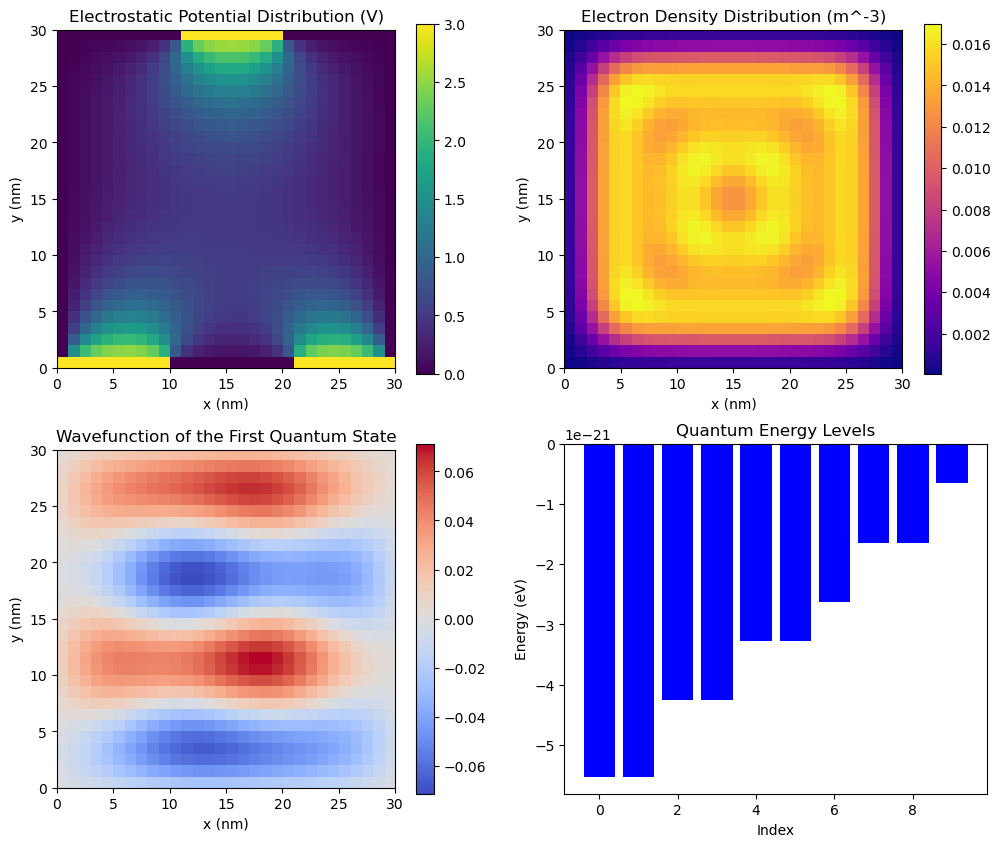

In [2]:
#simulation parameter
Nx, Ny = 30, 30  # 2D  
grid_shape = (Nx, Ny)
dx = dy = 1e-9   
#input parameter
epsilon = 11.7 * const.epsilon_0   
effective_mass = 0.19   
temperature = 300   
fermi_level = 1.5  
doping_profile = np.ones(grid_shape) * 5e18

bias_conditions = [3, 3, 3, 0]  # Zero potential at all boundaries

m_eff = 0.067 * const.m_e
E_0 = 1 #Conduction band energy
psi = np.zeros((30,30))#Placeholder for potential values
E_c = E_0 - psi

def amorphous_dos(energy, E_c=0.5, sigma=0.1):
    """
    A simple exponential DOS for amorphous materials near the conduction band.
    Args:
    - energy: the energy at which to evaluate the DOS.
    - E_c: conduction band energy (can be adjusted based on material properties).
    - sigma: broadening parameter for the DOS.
    """
    return np.exp(-(energy - E_c)**2 / (2 * sigma**2))  # Gaussian-like decay


#Solver
solver2D = SchrodingerPoissonSolver2D(grid_shape, epsilon, effective_mass, doping_profile, temperature, fermi_level, bias_conditions)
phi, energy_levels, wavefunctions, n_final = solver2D.solve()

#visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# (1)
ax1 = axes[0, 0]
im1 = ax1.imshow(phi, cmap="viridis", extent=[0, Nx*dx*1e9, 0, Ny*dy*1e9])
ax1.set_title("Electrostatic Potential Distribution (V)")
ax1.set_xlabel("x (nm)")
ax1.set_ylabel("y (nm)")
fig.colorbar(im1, ax=ax1)

# (2)  
ax2 = axes[0, 1]
im2 = ax2.imshow(n_final, cmap="plasma", extent=[0, Nx*dx*1e9, 0, Ny*dy*1e9])
ax2.set_title("Electron Density Distribution (m^-3)")
ax2.set_xlabel("x (nm)")
ax2.set_ylabel("y (nm)")
fig.colorbar(im2, ax=ax2)

# (3)  
ax3 = axes[1, 0]
im3 = ax3.imshow(wavefunctions[:, :, 0], cmap="coolwarm", extent=[0, Nx*dx*1e9, 0, Ny*dy*1e9])
ax3.set_title("Wavefunction of the First Quantum State")
ax3.set_xlabel("x (nm)")
ax3.set_ylabel("y (nm)")
fig.colorbar(im3, ax=ax3)

# (4)  
ax4 = axes[1, 1]
ax4.bar(range(len(energy_levels)), energy_levels, color="blue", label="Energy Levels (eV)")
ax4.set_title("Quantum Energy Levels")
ax4.set_xlabel("Index")
ax4.set_ylabel("Energy (eV)")
ax4.legend

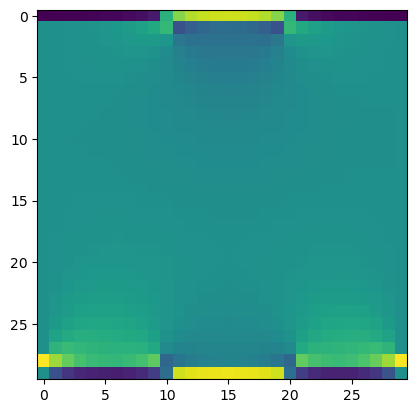

In [36]:
def charge_transport():
    e = 1.602e-19
    h_x = 30e-9/(len(phi[0])) 
    h_y = 30e-9/(len(phi))
    #n = 10 #Placeholder for number of electrons, leaving out for now
    mu_n = 1 #Placeholder for now
    E_x_array = np.zeros((len(phi),len(phi[0])))
    E_y_array = np.zeros((len(phi),len(phi[0])))
    J_x = np.zeros((len(phi),len(phi[0])))
    J_y = np.zeros((len(phi),len(phi[0])))
    for i in range(len(phi)):
        for j in range(len(phi[i])):
            if j == 0 and i==0:
             E_x = (phi[i,j+1]- phi[i,len(phi[i])-1])/h_x
             E_y = (phi[i+1,j] - phi[len(phi)-1,j])/h_y
            elif i == 0 and (j != 0 and j!= len(phi[i])-1):#Periodic boundary conidtion for x = 0 
             E_x = (phi[i,j+1]- phi[i,j-1])/h_x
             E_y = (phi[i+1,j] - phi[i-1,j])/h_y
            elif j == 0 and (i !=0 and i != len(phi)-1): #Periodic boundary condition for y = 0
             E_x = (phi[i,j+1]- phi[i,len(phi[i])-1])/h_x
             E_y = (phi[i+1,j] - phi[i-1,j])/h_y
            elif j == len(phi[i])-1 and (i !=0 and i!= len(phi) -1): #Periodic boundary condition for y = 0
             E_x = (phi[i,0]- phi[i,j-1])/h_x
             E_y = (phi[i+1,j] - phi[i-1,j])/h_y 
            elif j ==len(phi[i]) -1 and i ==0: #Periodic boundary condition for y = 0
             E_x = (phi[i,0]- phi[i,j-1])/h_x
             E_y = (phi[i+1,j] - phi[len(phi)-1,j])/h_y 
            elif j ==0 and i == len(phi)-1:
              E_x = (phi[i,j+1]- phi[i,len(phi[i])-1])/h_x
              E_y = (phi[0,j] - phi[i-1,j])/h_y 
            elif i == len(phi)-1 and (j!= 0 and j!= len(phi[i])-1):
              E_x = (phi[i,j+1]- phi[i,j-1])/h_x
              E_y = (phi[0,j] - phi[i-1,j])/h_y 
            elif i == len(phi)-1 and j == len(phi[i])-1:
              E_x = (phi[i,0]- phi[i,j-1])/h_x
              E_y = (phi[0,j] - phi[i-1,j])/h_y 
            else: #All interior points
             E_x = (phi[i,j+1]- phi[i,j-1])/h_x
             E_y = (phi[i+1,j] - phi[i-1,j])/h_y    
            J_x[i,j] = e*mu_n*E_x
            J_y[i,j] = e*mu_n*E_y

    return J_x,J_y

    
    


plt.imshow(charge_transport()[1])



